## Импорт библиотек

In [ ]:
import os

import pandas as pd
import numpy as np
import re
import spacy
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load("en_core_web_sm")

## Загрузка данных для обучения и тестирования

In [2]:
dataset_path = "E:/ML_NLP/spam_ham_dataset" 

data = []  

# Проходим по папкам 1/ - 6/

for folder in os.listdir(dataset_path):  
    folder_path = os.path.join(dataset_path, folder)
    
    if os.path.isdir(folder_path):  
        for label in ['spam', 'ham']: 
            label_path = os.path.join(folder_path, label)
            
            if os.path.isdir(label_path):  
                for filename in os.listdir(label_path):  
                    file_path = os.path.join(label_path, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                            text = f.read()  
                            data.append({'text': text, 'label': label})  
                    except Exception as e:
                        print(f"Ошибка с файлом {file_path}: {e}")

# Превращаем в DataFrame

df = pd.DataFrame(data)  
df.head()  


,text,label
0,Subject: dobmeos with hgh my energy level has ...,spam
1,Subject: your prescription is ready . . oxwq s...,spam
2,Subject: get that new car 8434\npeople nowthe ...,spam
3,"Subject: await your response\ndear partner ,\n...",spam
4,"Subject: coca cola , mbna america , nascar par...",spam


## Функция предобработки текста

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    text = re.sub(r'^Subject\s*:?[ ]*', '', text, flags=re.IGNORECASE)

    doc = nlp(text.lower())

    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

df['text_cleaned'] = df['text'].apply(preprocess_text)
df[['text', 'text_cleaned']].head()

,text,text_cleaned
0,Subject: dobmeos with hgh my energy level has ...,dobmeo hgh energy level go stukm introduce doc...
1,Subject: your prescription is ready . . oxwq s...,prescription ready oxwq s f e low cost prescri...
2,Subject: get that new car 8434\npeople nowthe ...,new car people nowthe weather climate particul...
3,"Subject: await your response\ndear partner ,\n...",await response dear partner team government of...
4,"Subject: coca cola , mbna america , nascar par...",coca cola mbna america nascar partner otcbb im...


## Векторизация очищенного текста

In [ ]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['text_cleaned'])

y = df['label'].map({'ham': 0, 'spam': 1})

## Деление на обучающую и тестовую выборки

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение моделей

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f"{name} обучена!")


Logistic Regression обучена!
Naive Bayes обучена!
Random Forest обучена!
SVM обучена!
KNN обучена!


## Оценка качаества моделей

In [ ]:
for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3334
           1       0.97      0.99      0.98      3409

    accuracy                           0.98      6743
   macro avg       0.98      0.98      0.98      6743
weighted avg       0.98      0.98      0.98      6743


--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3334
           1       0.97      0.99      0.98      3409

    accuracy                           0.98      6743
   macro avg       0.98      0.98      0.98      6743
weighted avg       0.98      0.98      0.98      6743


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3334
           1       0.98      0.99      0.98      3409

    accuracy                           0.98      6743
   macro avg       0.98      0.98      0.98      6743
w

## Визуализация результатов
### Матрица ошибок

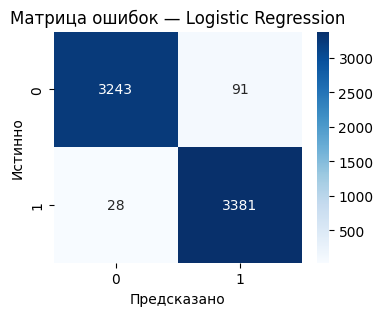

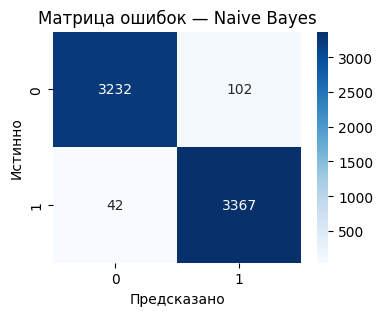

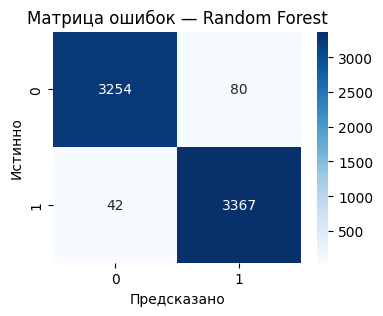

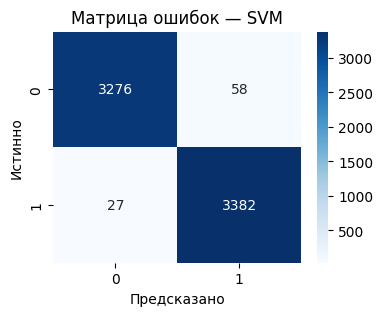

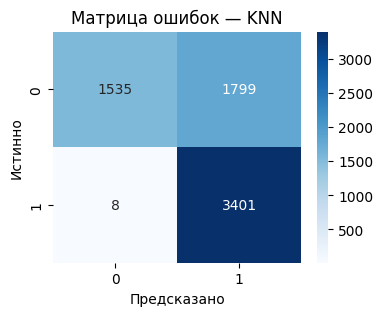

In [ ]:
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок — {model_name}')
    plt.xlabel('Предсказано')
    plt.ylabel('Истинно')
    plt.show()

for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    plot_conf_matrix(y_test, y_pred, name)

### Построение ROC-кривой

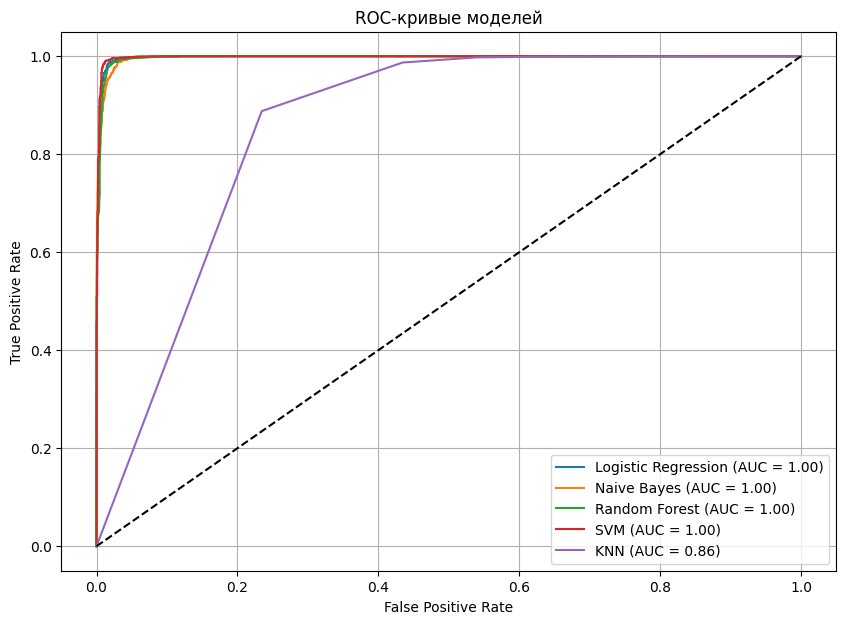

In [ ]:
plt.figure(figsize=(10, 7))

for name, model in fitted_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1] 
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия — случайное угадывание
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Визуализация нескольких случайных электорнных писем из тестовой выборки с предсказаниями моделей

In [ ]:
sample_indices = random.sample(range(X_test.shape[0]), 5)

for idx in sample_indices:
    original_text = df.iloc[idx]['text']
    true_label = y_test.iloc[idx]

    print("="*80)
    print(f" Письмо:\n{original_text[8:]}")
    print(f" Истинная метка: {'SPAM' if true_label else 'HAM'}")

    for name, model in fitted_models.items():
        pred = model.predict(X_test[idx]
)[0]
        print(f" Модель {name} предсказала: {'SPAM' if pred else 'HAM'}")


 Письмо:
 jan noms
- - - - - - - - - - - - - - - - - - - - - - forwarded by ami chokshi / corp / enron on 12 / 28 / 99 10 : 51
am - - - - - - - - - - - - - - - - - - - - - - - - - - -
troy _ a _ benoit @ reliantenergy . com on 12 / 28 / 99 10 : 47 : 23 am
to : ami chokshi / corp / enron @ enron
cc :
subject : jan noms
( see attached file : egmnom - jan . xls )
- egmnom - jan . xls
 Истинная метка: HAM
 Модель Logistic Regression предсказала: HAM
 Модель Naive Bayes предсказала: HAM
 Модель Random Forest предсказала: HAM
 Модель SVM предсказала: HAM
 Модель KNN предсказала: HAM
 Письмо:
 enron
damn ! ! ! ! what are you guys doing down there . i leave you alone and the place goes to hell in a hand - basket .
i ' m sure glad my portfolio is diversified into stocks that have lost even more money than enron ( chuckle ) .
hang in there . . . . . . . . . this has happened before . if it gets bad enough call me and i ' ll buy you lunch .
ken
p . s . i finally get to see my beloved huskers in w